In [1]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

impl_volatility = 'impl_volatility_h_1_step'

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')
# data_all_sso = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso.parquet')

# # data_train_sso = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_scaled_sso.parquet')
# data_train_all = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized.parquet')

# data_test_sso = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_standardized_sso.parquet')
# data_test_all = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled.parquet')

# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]

basic = ['moneyness', 'T']
option_specific = ['cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv']
macro_features = ['2Y_bond','FF_rate', 'gold_price','reces_indi', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', "vol_stock", 'RET', 'spread_stock']

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]


totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers

totalList_standardize = totalList + ['impl_volatility', 'date', 'ticker']


# Standardize my traning data

In [64]:
# unique_tickers = data_train_all['Ticker'].unique()


# for ticker in unique_tickers:
#     ticker_data = data_train_all[data_train_all['Ticker'] == ticker]
#     mean_values = ticker_data.drop(columns=['date', 'Ticker']).mean()
#     std_values = ticker_data.drop(columns=['date', 'Ticker']).std()
#     print(f"Ticker: {ticker}")
#     print("Mean values:")
#     print(mean_values)
#     print("\nStandard Deviation values:")
#     print(std_values)
#     print("\n" + "-"*50 + "\n")

In [65]:
# mean_values = data_train_all.drop(columns=['date', 'Ticker']).mean()
# std_values = data_train_all.drop(columns=['date', 'Ticker']).std()
# print("Mean values:")
# print(mean_values)
# print("\nStandard Deviation values:")
# print(std_values)
# print("\n" + "-"*50 + "\n")

Retraining final ElasticNet model on combined 2019 and 2020 data...


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.805e+03, tolerance: 3.163e+00
  model = cd_fast.enet_coordinate_descent(


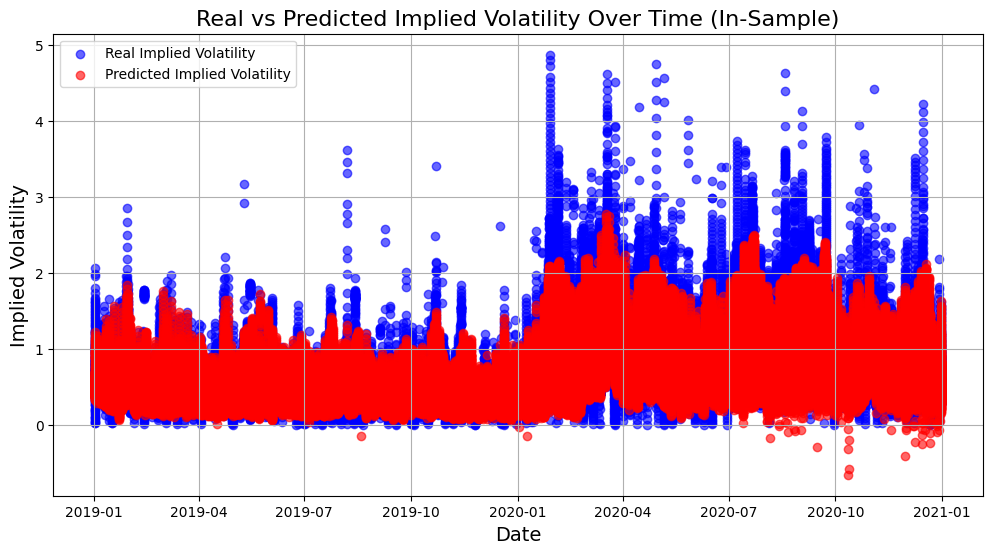

In-sample RMSE: 0.2592
In-sample R²: 0.6328


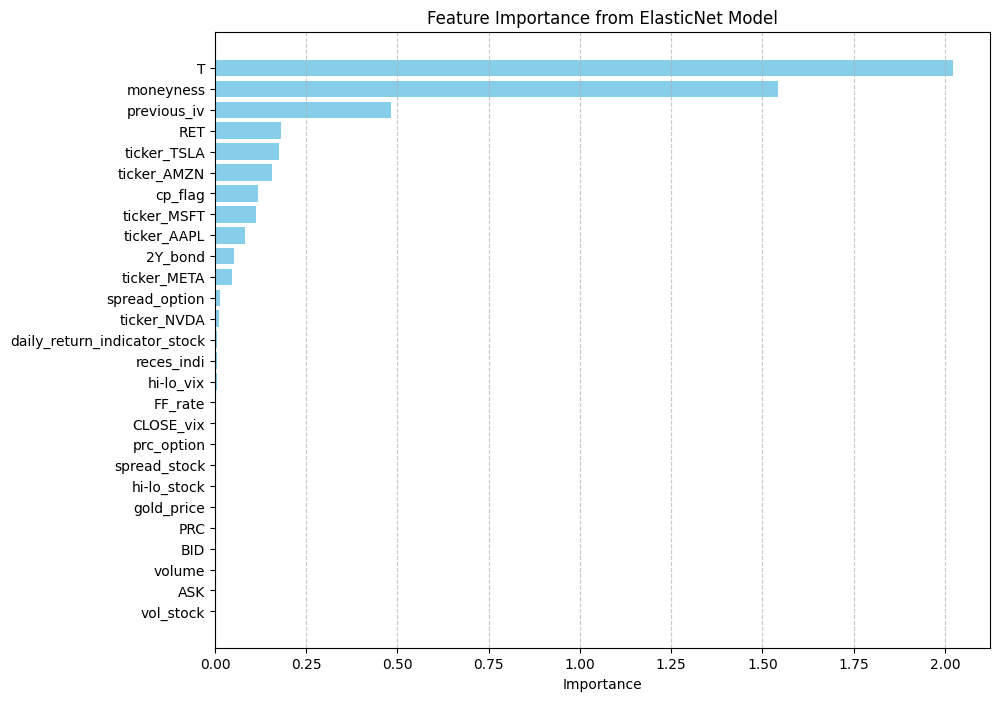

Final model, scaler, and selected features have been saved.


In [10]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

def retrain_final_model_enet(IV, data, selected_features, alpha, l1_ratio, verbose=0):
    """
    Retrain the final ElasticNet model on combined 2019 and 2020 data with specified parameters
    and plot feature importance.
    """
    if verbose >= 1:
        print("Retraining final ElasticNet model on combined 2019 and 2020 data...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    # Standardize the combined data
    # final_scaler = StandardScaler()
    # combined_x_scaled = final_scaler.fit_transform(combined_x)

    # Train ElasticNet with the specified parameters
    final_model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=10000
    )
    final_model.fit(combined_x, combined_y)

    # In-sample predictions and score calculation
    y_pred_in_sample = final_model.predict(combined_x)
    in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
    in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

    plot_real_vs_predicted(combined_data, combined_y, y_pred_in_sample, 'In-Sample')

    if verbose >= 1:
        print(f"In-sample RMSE: {in_sample_rmse:.4f}")
        print(f"In-sample R²: {in_sample_r2:.4f}")

    # Identify non-zero coefficients for selected features
    selected_features_final = [feature for feature, coef in zip(selected_features, final_model.coef_) if coef != 0]

    # Extract and sort feature importances
    importance = np.abs(final_model.coef_)
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importance
    }).query("Importance > 0").sort_values(by='Importance', ascending=True)

    # Plot feature importance as a horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance from ElasticNet Model')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Save the final model, scaler, and selected features
    joblib.dump(final_model, 'final_elasticnet_model.pkl')
    # joblib.dump(final_scaler, 'final_scaler.pkl')
    joblib.dump(selected_features_final, 'selected_features.pkl')

    print("Final model, scaler, and selected features have been saved.")
    return final_model, selected_features_final

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for Real Implied Volatility
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
    # Scatter plot for Predicted Implied Volatility
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
    # Labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
    # Add a legend
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Directly use known best parameters
alpha = 1e-6
l1_ratio = 0.5

# Split data into training (2019) and validation (2020)
train_data = data[data['date'].dt.year == 2019]
val_data = data[data['date'].dt.year == 2020]
train_x = train_data[totalList]
train_y = train_data[impl_volatility]

# Evaluate the ElasticNet model using walk-forward validation
# evaluate_model_enet(alpha, l1_ratio, train_x, train_y, val_data, 'impl_volatility', totalList, verbose=1)

# Retrain the final model on the combined dataset
final_elasticnet_model, selected_features_final = retrain_final_model_enet(
    impl_volatility, data, totalList, alpha, l1_ratio, verbose=1
)


In [3]:
selected_features_final

['moneyness',
 'T',
 '2Y_bond',
 'FF_rate',
 'gold_price',
 'reces_indi',
 'CLOSE_vix',
 'hi-lo_vix',
 'cp_flag',
 'spread_option',
 'volume',
 'prc_option',
 'previous_iv',
 'BID',
 'ASK',
 'daily_return_indicator_stock',
 'hi-lo_stock',
 'PRC',
 'vol_stock',
 'RET',
 'spread_stock',
 'ticker_AAPL',
 'ticker_AMZN',
 'ticker_META',
 'ticker_MSFT',
 'ticker_NVDA',
 'ticker_TSLA']

Retraining final ElasticNet model on combined 2019 and 2020 data...
In-sample RMSE: 0.2592
In-sample R²: 0.6328


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.016e+03, tolerance: 3.163e+00
  model = cd_fast.enet_coordinate_descent(


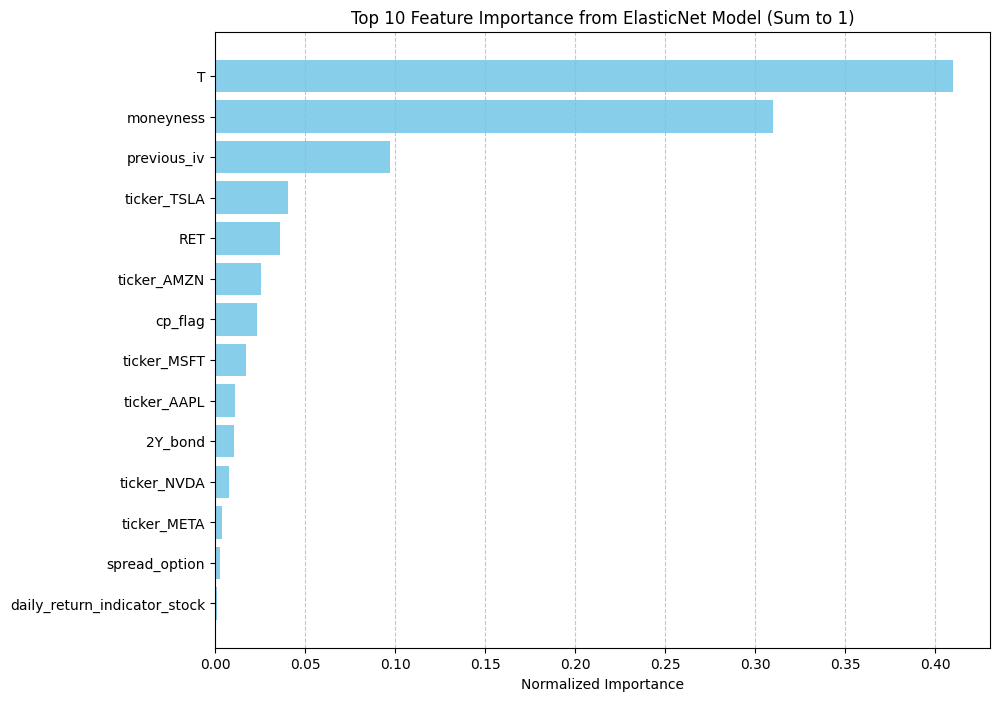

Final model, scaler, and selected features have been saved.


In [11]:
import joblib
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def retrain_final_model_enet(IV, data, selected_features, alpha, l1_ratio, verbose=0):
    """
    Retrain the final ElasticNet model on combined 2019 and 2020 data with specified parameters
    and plot feature importance.
    """
    if verbose >= 1:
        print("Retraining final ElasticNet model on combined 2019 and 2020 data...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    # Train ElasticNet with the specified parameters
    final_model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=10000
    )
    final_model.fit(combined_x, combined_y)

    # In-sample predictions and score calculation
    y_pred_in_sample = final_model.predict(combined_x)
    in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
    in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

    if verbose >= 1:
        print(f"In-sample RMSE: {in_sample_rmse:.4f}")
        print(f"In-sample R²: {in_sample_r2:.4f}")

    # Identify non-zero coefficients for selected features and create a DataFrame
    importance = np.abs(final_model.coef_)
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importance
    }).query("Importance > 0").sort_values(by='Importance', ascending=False)

    # Normalize importances to sum to 1
    total_importance = importance_df['Importance'].sum()
    importance_df['Normalized Importance'] = importance_df['Importance'] / total_importance

    # Select the top 10 features and plot their normalized importance
    top_10_features_df = importance_df.head(14)

    plt.figure(figsize=(10, 8))
    plt.barh(top_10_features_df['Feature'], top_10_features_df['Normalized Importance'], color='skyblue')
    plt.xlabel('Normalized Importance')
    plt.title('Top 10 Feature Importance from ElasticNet Model (Sum to 1)')
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Save the final model and selected features
    joblib.dump(final_model, 'final_elasticnet_model.pkl')
    joblib.dump(selected_features_final, 'selected_features.pkl')

    print("Final model, scaler, and selected features have been saved.")
    return final_model, selected_features_final, top_10_features_df

# Plot function for in-sample predictions
def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have defined alpha, l1_ratio, selected_features_final, and other relevant data
alpha = 1e-6
l1_ratio = 1

# Retrain the final model on the combined dataset and plot top 10 normalized features
final_elasticnet_model, selected_features_final, top_10_features_df = retrain_final_model_enet(
    impl_volatility, data, totalList, alpha, l1_ratio, verbose=1
)


In [5]:
top_10_features_df["Normalized Importance"].tolist()
# top_10_features_df["Feature"].tolist()
# top_10_features_df

[0.4097617803203388,
 0.309844773568098,
 0.09690111833147268,
 0.040695318664402166,
 0.035951959299127756,
 0.025586511629908996,
 0.023569065831390353,
 0.017020891014648286,
 0.01090432422671971,
 0.01042763740513447,
 0.007854409786885484,
 0.003699954532093201,
 0.0025214272770951976,
 0.0013764163259580577]

/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.016e+03, tolerance: 3.163e+00
  model = cd_fast.enet_coordinate_descent(


Baseline R² (OOS): 0.5585
Feature: moneyness, Baseline R²: 0.5585, Perturbed R²: -19.1490, Absolute Change: 19.7076
Feature: T, Baseline R²: 0.5585, Perturbed R²: 0.5592, Absolute Change: 0.0006
Feature: 2Y_bond, Baseline R²: 0.5585, Perturbed R²: 0.5621, Absolute Change: 0.0036
Feature: FF_rate, Baseline R²: 0.5585, Perturbed R²: 0.5585, Absolute Change: 0.0001
Feature: gold_price, Baseline R²: 0.5585, Perturbed R²: 0.0631, Absolute Change: 0.4954
Feature: reces_indi, Baseline R²: 0.5585, Perturbed R²: 0.5575, Absolute Change: 0.0011
Feature: CLOSE_vix, Baseline R²: 0.5585, Perturbed R²: 0.5512, Absolute Change: 0.0074
Feature: hi-lo_vix, Baseline R²: 0.5585, Perturbed R²: 0.5660, Absolute Change: 0.0075
Feature: cp_flag, Baseline R²: 0.5585, Perturbed R²: 0.5285, Absolute Change: 0.0300
Feature: spread_option, Baseline R²: 0.5585, Perturbed R²: 0.5531, Absolute Change: 0.0055
Feature: volume, Baseline R²: 0.5585, Perturbed R²: 0.5479, Absolute Change: 0.0106
Feature: prc_option, Base

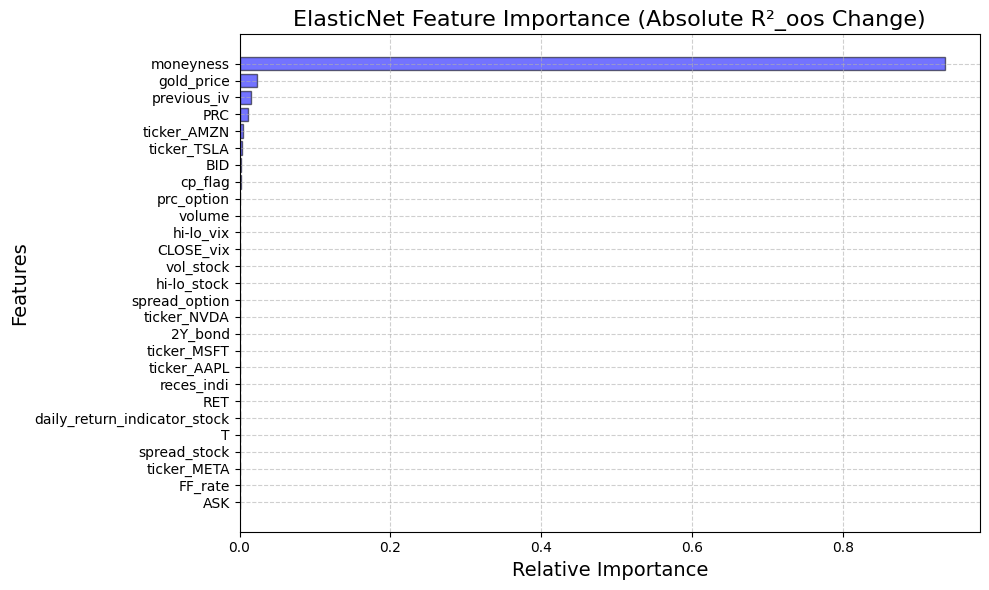

In [12]:
def calculate_feature_importance_r2_enet(data_train, data_test, features, target, alpha, l1_ratio):
    """
    Calculate feature importance for ElasticNet based on the absolute change in R²_oos when a feature is set to zero.

    Parameters:
    - data_train: Training dataset
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - alpha: ElasticNet regularization parameter
    - l1_ratio: ElasticNet mixing parameter (0 = Ridge, 1 = Lasso)
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Train the ElasticNet model
    X_train = data_train[features]
    y_train = data_train[target]
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    model.fit(X_train, y_train)

    # Calculate baseline R²_oos
    X_test = data_test[features]
    y_test = data_test[target]
    y_test_pred = model.predict(X_test)
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the absolute change in R²_oos for each feature
    r2_changes = []
    for feature in features:
        # Perturb the test data by setting the feature to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[feature] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed)
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_change = abs(baseline_r2 - r2_zeroed)  # Use absolute value of the change
        r2_changes.append(r2_change)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Absolute Change: {r2_change:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_changes)
    r2_importance = r2_importance / r2_importance.sum()

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Calculate feature importance for ElasticNet based on R²_oos
feature_importance_enet, baseline_r2_enet = calculate_feature_importance_r2_enet(
    data_train=data,
    data_test=datat,
    features=totalList,
    target=impl_volatility,
    alpha=alpha,
    l1_ratio=l1_ratio
)

# Print and visualize the feature importance
print("Feature Importance (Absolute R²_oos Change) for ElasticNet:")
print(feature_importance_enet)

plot_feature_importance(feature_importance_enet, title="ElasticNet Feature Importance (Absolute R²_oos Change)")


In [8]:
feature_importance_enet["Importance"].tolist()
# feature_importance_enet["Feature"].tolist()

[0.9347643143409546,
 0.023499265747079567,
 0.014734452507048612,
 0.01157293592768035,
 0.004983590384893675,
 0.0033769234893406197,
 0.0015538391003582911,
 0.0014226593394337963,
 0.0012774023932700315,
 0.000503451703301797,
 0.00035422758954333107,
 0.00035037212927202234,
 0.000304131139443323,
 0.0002903740116483821,
 0.0002603914938770944,
 0.0002087435528256975,
 0.00016888481007433523,
 0.00013959801006038097,
 5.2127958914887874e-05,
 5.0887424624605554e-05,
 3.65329981101288e-05,
 3.1273361214308597e-05,
 3.0152202974683412e-05,
 2.3074789898840818e-05,
 5.720440422438566e-06,
 3.376867811594186e-06,
 1.2962859225330073e-06]

In [107]:
top_10_features_df["Feature"].tolist()

['T',
 'moneyness',
 'previous_iv',
 '2Y_bond',
 '1Y_bond',
 'ticker_TSLA',
 '10Y_RIR',
 'cp_flag',
 'RET',
 'ticker_AMZN']

In [90]:
# import joblib
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt

# def predict_test_data_per_ticker(IV, train_data, test_data, model, selected_features):
#     """
#     Predict the target variable for the test set using the trained model and scale data with MinMaxScaler.
    
#     Parameters:
#     IV (str): The name of the independent variable to predict.
#     train_data (pd.DataFrame): The training dataset used for fitting the scaler.
#     test_data (pd.DataFrame): The test dataset.
#     model: The trained ElasticNet model.
#     selected_features (list): The list of features selected by ElasticNet during training.
    
#     Returns:
#     list: RMSE and R² values for each ticker in the test set.
#     """
#     # Initialize MinMaxScaler and fit it on the entire training set
#     # scaler = StandardScaler()
#     # scaler.fit(train_data[selected_features])  # Fit on training data only

#     results_list_all = []  # Initialize list to store results
#     unique_tickers = test_data['Ticker'].unique()
    
#     for ticker in unique_tickers:
#         # Filter the data for the current ticker
#         data_ticker = test_data[test_data['Ticker'] == ticker]
        
#         # Separate features and target for the ticker
#         y_ticker_actual = data_ticker[IV]
#         X_ticker = data_ticker[selected_features]
        
#         # Scale the test data using the scaler fitted on the training data
#         # X_ticker_scaled = scaler.transform(X_ticker)
#         # Predict implied volatility using the trained model
#         y_ticker_pred = model.predict(X_ticker)
        
#         # Calculate RMSE and R² for the ticker-specific implied volatility prediction
#         rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
#         r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)
        
#         # Save results in the list
#         results_list_all.append({
#             'Ticker': ticker,
#             'RMSE': rmse_ticker,
#             'R²': r2_ticker
#         })
#         print(f'{ticker} RMSE: {rmse_ticker}')
#         print(f'{ticker} R²: {r2_ticker}')

#         # Plot Real vs Predicted values
#         plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

#     return results_list_all

# def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
#     """
#     Plot Real vs Predicted Implied Volatility over time.

#     Parameters:
#     test_data (pd.DataFrame): The test dataset containing the date information.
#     real_values (np.array or pd.Series): The real implied volatility values.
#     predicted_values (np.array or pd.Series): The predicted implied volatility values.
#     title (str): The title for the plot.
#     """
#     plt.figure(figsize=(12, 6))
    
#     # Scatter plot for Real Implied Volatility
#     plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
#     # Scatter plot for Predicted Implied Volatility
#     plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
#     # Labels and title
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel('Implied Volatility', fontsize=14)
#     plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
#     # Add a legend
#     plt.legend()
    
#     # Grid for better visualization
#     plt.grid(True)
    
#     # Display the plot
#     plt.show()

# # Assuming `data_test_all`, `data_train_tot`, and `selected_features_final` are already defined
# results_list_all = predict_test_data_per_ticker(
#     'impl_volatility', data, datat, final_elasticnet_model, totalList
# )


AAPL RMSE: 0.18857019027389546
AAPL R²: -0.21243724431442512


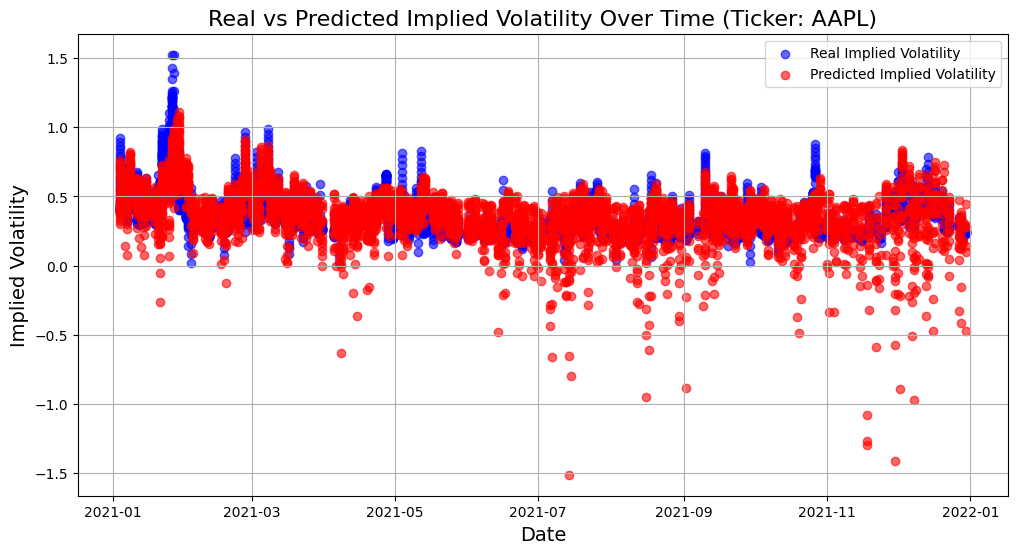

AMZN RMSE: 0.2197868230963306
AMZN R²: 0.23836020034335914


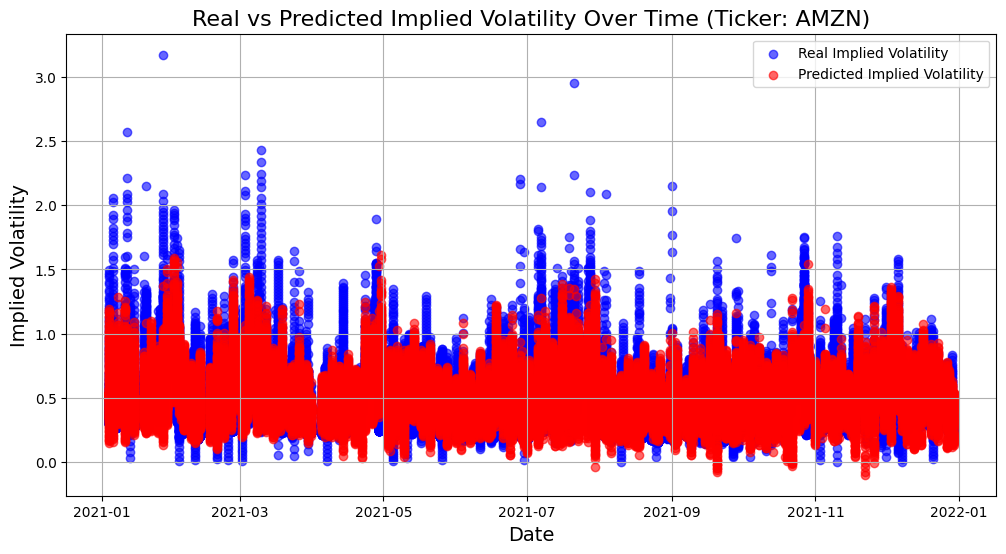

NVDA RMSE: 0.25916341366057943
NVDA R²: 0.3242070989673369


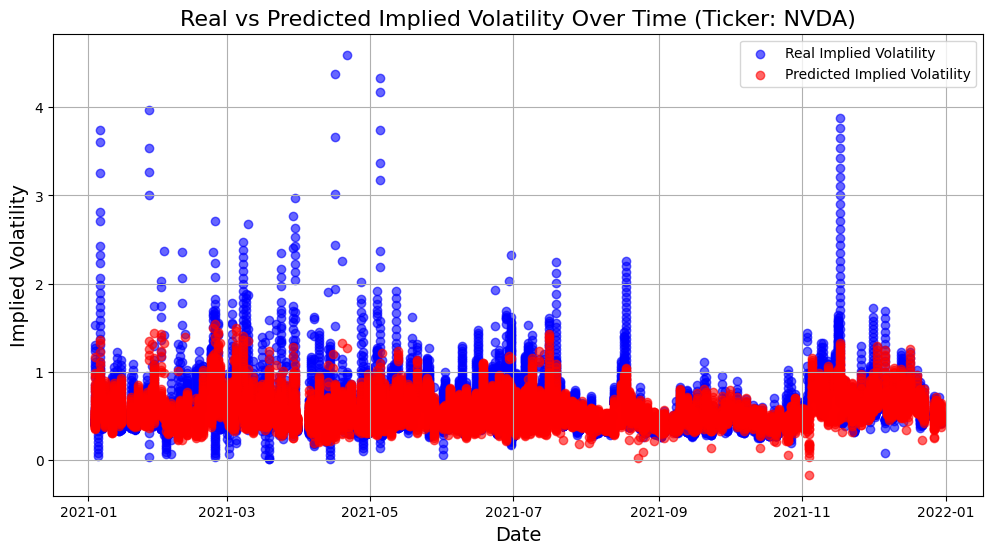

TSLA RMSE: 0.2928740126052254
TSLA R²: 0.5483533237510168


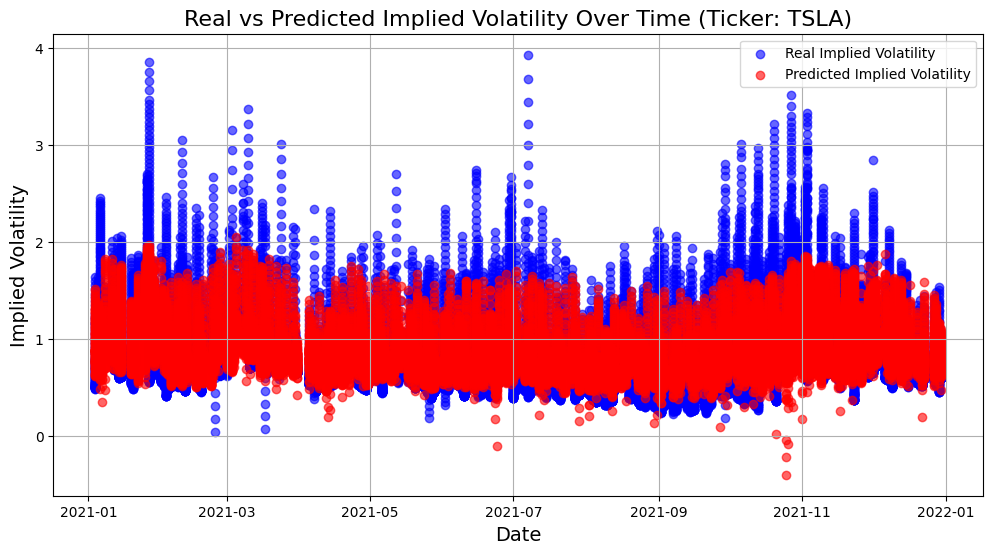

META RMSE: 0.16664696721784006
META R²: 0.31359345553476436


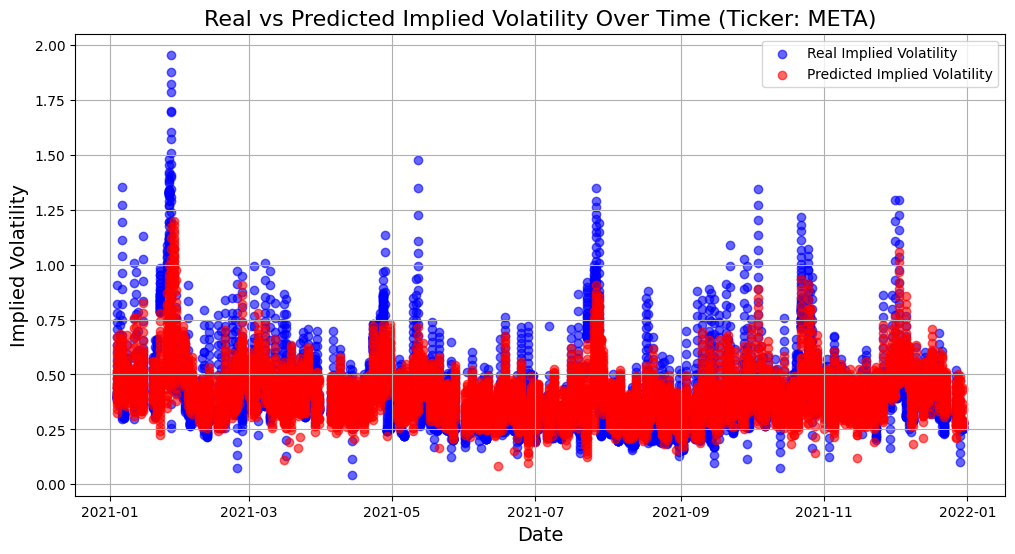

MSFT RMSE: 0.11536629783168637
MSFT R²: 0.3202034978257199


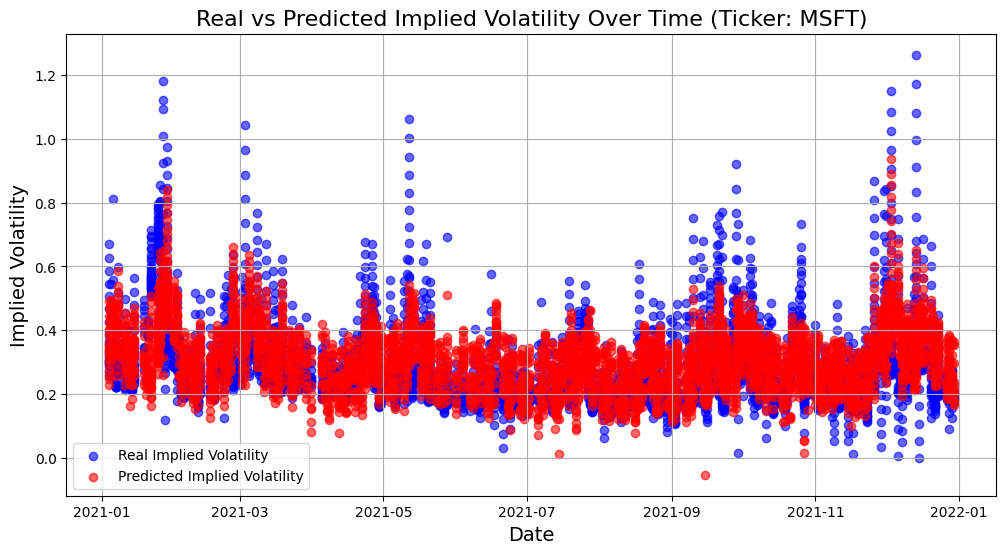

Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.006952309252328778
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/enet_all.csv
Overall Weighted RMSE: 0.2363919591060455
Overall Weighted R²: 0.3083355865322014
Overall Combined RMSE: 0.2363919591060455
Overall Combined R²: 0.5585434187929625
Overall Weighted RMSE: 0.2363919591060455
Overall Weighted R²: 0.3083355865322014
Overall Combined RMSE: 0.2363919591060455
Overall Combined R²: 0.5585434187929625
Ticker-Specific Results:
{'Ticker': 'AAPL', 'RMSE': 0.18857019027389546, 'R²': -0.21243724431442512}
{'Ticker': 'AMZN', 'RMSE': 0.2197868230963306, 'R²': 0.23836020034335914}
{'Ticker': 'NVDA', 'RMSE': 0.25916341366057943, 'R²': 0.3242070989673369}
{'Ticker': 'TSLA', 'RMSE': 0.2928740126052254, 'R²': 0.5483533237510168}
{'Ticker': 'META', 'RMSE': 0.16664696721784006, 'R²': 

In [9]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term



def predict_test_data_per_ticker(IV, train_data, test_data, model, selected_features):
    """
    Predict the target variable for the test set using the trained model and calculate weighted RMSE and R².
    Also computes combined RMSE and R² using all data without weighting.

    Parameters:
    IV (str): The name of the independent variable to predict.
    train_data (pd.DataFrame): The training dataset used for fitting the scaler.
    test_data (pd.DataFrame): The test dataset.
    model: The trained ElasticNet model.
    selected_features (list): The list of features selected by ElasticNet during training.

    Returns:
    dict: Dictionary containing RMSE and R² values for each ticker, overall weighted metrics, 
          and combined overall metrics.
    """
    results_list_all = []  # Initialize list to store results
    unique_tickers = test_data['Ticker'].unique()

    # Initialize accumulators for overall RMSE and R²
    total_rmse_weighted_sum = 0
    total_r2_weighted_sum = 0
    total_observations = 0

    # Collect all actual and predicted values for combined metrics
    combined_actual = []
    combined_predicted = []

    for ticker in unique_tickers:
        # Filter the data for the current ticker
        data_ticker = test_data[test_data['Ticker'] == ticker]

        # Separate features and target for the ticker
        y_ticker_actual = data_ticker[IV]
        X_ticker = data_ticker[selected_features]

        # Predict implied volatility using the trained model
        y_ticker_pred = model.predict(X_ticker)

        # Collect predictions and actual values for combined calculation
        combined_actual.extend(y_ticker_actual)
        combined_predicted.extend(y_ticker_pred)

        # Calculate RMSE and R² for the ticker-specific implied volatility prediction
        rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
        r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)

        # Calculate the number of observations for the ticker
        num_observations = len(y_ticker_actual)

        # Weight RMSE and R² by the number of observations
        total_rmse_weighted_sum += num_observations * rmse_ticker**2
        total_r2_weighted_sum += num_observations * r2_ticker
        total_observations += num_observations

        # Save results in the list
        results_list_all.append({
            'Ticker': ticker,
            'RMSE': rmse_ticker,
            'R²': r2_ticker
        })
        print(f'{ticker} RMSE: {rmse_ticker}')
        print(f'{ticker} R²: {r2_ticker}')

        # Plot Real vs Predicted values
        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    # Calculate overall weighted RMSE and R²
    overall_rmse = np.sqrt(total_rmse_weighted_sum / total_observations)
    overall_r2 = total_r2_weighted_sum / total_observations

    # Calculate combined overall RMSE and R² using all data
    combined_actual = np.array(combined_actual)
    combined_predicted = np.array(combined_predicted)

    # Calculate Newey-West standard error
    # Example calculation
    errors_test = combined_actual - combined_predicted
    datat['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in datat.columns:
        daily_avg_errors = datat.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a CSV
    file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/enet_all.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")

    
    overall_combined_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
    overall_combined_r2 = r2_score(combined_actual, combined_predicted)

    print(f'Overall Weighted RMSE: {overall_rmse}')
    print(f'Overall Weighted R²: {overall_r2}')
    print(f'Overall Combined RMSE: {overall_combined_rmse}')
    print(f'Overall Combined R²: {overall_combined_r2}')

    return {
        'Ticker_Results': results_list_all,
        'Overall_RMSE': overall_rmse,
        'Overall_R²': overall_r2,
        'Overall_Combined_RMSE': overall_combined_rmse,
        'Overall_Combined_R²': overall_combined_r2
    }

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming `data_test_all`, `data_train_tot`, and `selected_features_final` are already defined
results_all = predict_test_data_per_ticker(
    impl_volatility, data, datat, final_elasticnet_model, totalList
)

# Print overall weighted metrics
print(f"Overall Weighted RMSE: {results_all['Overall_RMSE']}")
print(f"Overall Weighted R²: {results_all['Overall_R²']}")
print(f"Overall Combined RMSE: {results_all['Overall_Combined_RMSE']}")
print(f"Overall Combined R²: {results_all['Overall_Combined_R²']}")

# Print ticker-specific results
print("Ticker-Specific Results:")
for ticker_result in results_all['Ticker_Results']:
    print(ticker_result)


In [ ]:
selected_features_final

['moneyness',
 'T',
 '1Y_bond',
 '2Y_bond',
 'FF_rate',
 'gold_price',
 'reces_indi',
 '10Y_RIR',
 'CLOSE_vix',
 'hi-lo_vix',
 'cp_flag',
 'spread_option',
 'volume',
 'prc_option',
 'previous_iv',
 'BID',
 'ASK',
 'daily_return_indicator_stock',
 'hi-lo_stock',
 'PRC',
 'vol_stock',
 'RET',
 'spread_stock',
 'ticker_AAPL',
 'ticker_AMZN',
 'ticker_META',
 'ticker_MSFT',
 'ticker_NVDA',
 'ticker_TSLA']

In [ ]:
# import joblib
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# def predict_test_data_per_ticker(IV, train_data, test_data, model, selected_features):
#     """
#     Predict the target variable for the test set using the trained model and scale data with StandardScaler.
    
#     Parameters:
#     IV (str): The name of the independent variable to predict.
#     train_data (pd.DataFrame): The training dataset used for fitting the scaler.
#     test_data (pd.DataFrame): The test dataset.
#     model: The trained ElasticNet model.
#     selected_features (list): The list of features selected by ElasticNet during training.
    
#     Returns:
#     list: RMSE and R² values for each ticker in the test set.
#     """
#     # Initialize StandardScaler and fit it on the entire training set
#     # scaler = StandardScaler()
#     # scaler.fit(train_data[selected_features])  # Fit on training data only

#     results_list_all = []  # Initialize list to store results
#     unique_tickers = test_data['Ticker'].unique()
    
#     for ticker in unique_tickers:
#         # Filter the data for the current ticker
#         data_ticker = test_data[test_data['Ticker'] == ticker]
        
#         # Separate features and target for the ticker
#         y_ticker_actual = data_ticker[IV]
#         X_ticker = data_ticker[selected_features]
        
#         # Scale the test data using the scaler fitted on the training data
#         # X_ticker_scaled = scaler.transform(X_ticker)
        
#         # Predict implied volatility using the trained model
#         y_ticker_pred = model.predict(X_ticker)
        
#         # Calculate RMSE and R² for the ticker-specific implied volatility prediction
#         rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
#         r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)
        
#         # Save results in the list
#         results_list_all.append({
#             'Ticker': ticker,
#             'RMSE': rmse_ticker,
#             'R²': r2_ticker
#         })
#         print(f'{ticker} RMSE: {rmse_ticker}')
#         print(f'{ticker} R²: {r2_ticker}')

#         plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

#     return results_list_all

# def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
#     """
#     Plot Real vs Predicted Implied Volatility over time.

#     Parameters:
#     test_data (pd.DataFrame): The test dataset containing the date information.
#     real_values (np.array or pd.Series): The real implied volatility values.
#     predicted_values (np.array or pd.Series): The predicted implied volatility values.
#     title (str): The title for the plot.
#     """
#     plt.figure(figsize=(12, 6))
    
#     # Scatter plot for Real Implied Volatility
#     plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
#     # Scatter plot for Predicted Implied Volatility
#     plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
#     # Labels and title
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel('Implied Volatility', fontsize=14)
#     plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
#     # Add a legend
#     plt.legend()
    
#     # Grid for better visualization
#     plt.grid(True)
    
#     # Display the plot
#     plt.show()

# # Assuming `data_test_all`, `data_train_tot`, and `selected_features_final` are already defined
# results_list_all = predict_test_data_per_ticker(
#     'impl_volatility', data, data_all_sso, final_elasticnet_model, totalList
# )


In [ ]:
# def predict_test_data_per_ticker(IV, train_data, test_data, model, selected_features):
#     """
#     Predict the target variable for the test set using the trained model and scale data with MinMaxScaler.
    
#     Parameters:
#     IV (str): The name of the independent variable to predict.
#     train_data (pd.DataFrame): The training dataset used for fitting the scaler.
#     test_data (pd.DataFrame): The test dataset.
#     model: The trained ElasticNet model.
#     selected_features (list): The list of features selected by ElasticNet during training.
    
#     Returns:
#     list: RMSE and R² values for each ticker in the test set.
#     """
#     # Initialize MinMaxScaler and fit it on the entire training set
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler.fit(train_data[selected_features])  # Fit on training data only

#     results_list_all = []  # Initialize list to store results
    
#     # Separate features and target for the ticker
#     y_ticker_actual = test_data[IV]
#     X_ticker = test_data[selected_features]
    
#     # Scale the test data using the scaler fitted on the training data
#     X_ticker_scaled = scaler.transform(X_ticker)
#     # Predict implied volatility using the trained model
#     y_ticker_pred = model.predict(X_ticker_scaled)
    
#     # Calculate RMSE and R² for the ticker-specific implied volatility prediction
#     rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
#     r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)
    
#     # Save results in the list
#     results_list_all.append({
#         'RMSE': rmse_ticker,
#         'R²': r2_ticker
#     })
#     print(f'RMSE: {rmse_ticker}')
#     print(f'R²: {r2_ticker}')
#     # Plot Real vs Predicted values
#     plot_real_vs_predicted(test_data, y_ticker_actual, y_ticker_pred)

#     return results_list_all

# def plot_real_vs_predicted(test_data, real_values, predicted_values):
#     """
#     Plot Real vs Predicted Implied Volatility over time.

#     Parameters:
#     test_data (pd.DataFrame): The test dataset containing the date information.
#     real_values (np.array or pd.Series): The real implied volatility values.
#     predicted_values (np.array or pd.Series): The predicted implied volatility values.
#     title (str): The title for the plot.
#     """
#     plt.figure(figsize=(12, 6))
    
#     # Scatter plot for Real Implied Volatility
#     plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
#     # Scatter plot for Predicted Implied Volatility
#     plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
#     # Labels and title
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel('Implied Volatility', fontsize=14)
#     plt.title(f'Real vs Predicted Implied Volatility Over Time)', fontsize=16)
    
#     # Add a legend
#     plt.legend()
    
#     # Grid for better visualization
#     plt.grid(True)
    
#     # Display the plot
#     plt.show()

# # Assuming `data_test_all`, `data_train_tot`, and `selected_features_final` are already defined
# results_list_all = predict_test_data_per_ticker(
#     'impl_volatility', data, datat, final_elasticnet_model, totalList)

In [ ]:
# Convert lists to DataFrames for easier plotting
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_all_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_all_rmse = plt.bar(x, results_list_all_df['RMSE'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_all_r2 = plt.bar(x, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.9])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


NameError: name 'results_list_all' is not defined

In [ ]:
results_list_all

[{'Ticker': 'META', 'RMSE': 0.2283940495649851, 'R²': 0.5631001308361556},
 {'Ticker': 'TSLA', 'RMSE': 0.2841579032667068, 'R²': 0.6133129795152987},
 {'Ticker': 'AMZN', 'RMSE': 0.22535783110333352, 'R²': 0.41007665215400424},
 {'Ticker': 'MSFT', 'RMSE': 0.21598994899569263, 'R²': 0.5308082742331308},
 {'Ticker': 'NVDA', 'RMSE': 0.26216132591198976, 'R²': 0.5302338841890262},
 {'Ticker': 'AAPL', 'RMSE': 0.22870454341832272, 'R²': 0.5275291642826003}]

In [ ]:
# # Function to calculate prediction errors
# def get_prediction_errors(actual, predicted):
#     """
#     Compute the prediction errors between actual and predicted values.
    
#     Parameters:
#     actual (pd.Series or np.array): The actual values of the independent variable.
#     predicted (np.array): The predicted values from the model.
    
#     Returns:
#     np.array: The error differences.
#     """
#     return actual - predicted

# # Function to calculate Newey-West standard error
# def newey_west_standard_error(errors, lag=1):
#     """
#     Computes the Newey-West standard error for the series of prediction errors.
    
#     Parameters:
#     - errors: Array-like of prediction errors
#     - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
#     Returns:
#     - Newey-West standard error of the prediction errors
#     """
#     X = np.ones(len(errors))  # Constant term
#     ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
#     nw_std_error = ols_model.bse[0]
#     return nw_std_error

# # Step 5: Calculate the Newey-West standard error for each set of errors
# nw_std_error_call = newey_west_standard_error(call_errors_enet, lag=1)
# nw_std_error_put = newey_west_standard_error(put_errors_enet, lag=1)

# # Step 6: Ensure both error lists have the same length by padding the shorter one with zeros
# max_length = max(len(call_errors_enet), len(put_errors_enet))

# call_errors_enet_padded = np.pad(call_errors_enet, (0, max_length - len(call_errors_enet)), 'constant', constant_values=0)
# put_errors_enet_padded = np.pad(put_errors_enet, (0, max_length - len(put_errors_enet)), 'constant', constant_values=0)

# # Step 7: Save the errors and Newey-West standard errors to a CSV file
# enet_test_data = pd.DataFrame({
#     'Call Errors': call_errors_enet_padded,
#     'Put Errors': put_errors_enet_padded,
#     'Call Newey-West Std Error': [nw_std_error_call] * max_length,
#     'Put Newey-West Std Error': [nw_std_error_put] * max_length
# })

# # Specify the file path for saving the errors and Newey-West standard errors
# file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_enet.csv'

# # Save the DataFrame to a new CSV file
# enet_test_data.to_csv(file_path, index=False)

# print(f"ElasticNet model test errors and Newey-West statistics saved to {file_path}")

